In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Model.layers has to be an NN ModuleList
class L2LWrapper:
    def __init__(
        self,
        model,
        chunks,
        cmp=True,
        parallel=False,
        loss_scale = 2**7,
    ):
        self.model = model
        self.is_cmp = cmp
        self.chunks = chunks
        self.is_parallel = parallel
        self.loss_scale = loss_scale
        self.master_params = self.compile_master(model)
        self._activations = []
        self._grads = []
        
        if self.is_cmp:
            self.model.half()

    def compile_master(self, model):
        master_params = [p.detach().clone().float() for p in model.parameters() if p.requires_grad==True]
        for p in master_params:
            p.requires_grad = True
        return master_params

    def zero_grad(self):
        for model, master in zip(self.model.parameters(), self.master_params):
            model.grad = None
            master.grad = None
        self._reset()
            
    def _reset(self):
        self._activations = []
        self._grads = []

    def model_grad_to_master(self):
        for model, master in zip(self.model.parameters(), self.master_params):
            if master.grad is None:
                master.grad = torch.empty_like(master.data).float()
            master.grad.data.copy_(model.grad.data)
            if self.loss_scale != 0:
                master.grad.data = master.grad.data / self.loss_scale
            
    def master_param_to_model(self):
        for model, master in zip(self.model.parameters(), self.master_params):
            model.data.copy_(master.data)
    
    @torch.no_grad()
    def compute_activations(self, x):
        if self.is_cmp:
            self._activations.append(x.half())
        else:
            self._activations.append(x)
        
        for idx, layer in enumerate(self.model.layers):
            layer.to("cuda")
            tmp_act = []
            for c_x in torch.chunk(self._activations[idx], self.chunks):
                out = layer(c_x.cuda())
                tmp_act.append(out.cpu())
            layer.to("cpu")
            
            gather = torch.cat(tmp_act, dim=0)
            self._activations.append(gather)
            
    def compute_loss(self, targets, criterion):
        acc_loss = 0.
        grads = []
        for pred, target in zip(torch.chunk(self._activations[-1], self.chunks), torch.chunk(targets, self.chunks)):
            cpred = pred.cuda().requires_grad_(True)
            ctarget = target.cuda()
            loss = criterion(cpred.float(), ctarget) / self.chunks
            acc_loss += loss.item() # Append Before Scaling
            if self.loss_scale != 0:
                loss *= self.loss_scale
            loss.backward()
            grads.append(cpred.grad.cpu())
        self._grads.append(torch.cat(grads, dim=0))
        return acc_loss
        
    def backward(self):
        for idx, (layer, preacts) in enumerate(zip(reversed(self.model.layers), reversed(self._activations[:-1]))):
            layer.to("cuda")
            grads = []
            for act, grad in zip(torch.chunk(preacts, self.chunks), torch.chunk(self._grads[idx], self.chunks)):
                cact = act.cuda().requires_grad_(True)
                out = layer(cact)
                out.backward(grad.cuda())
                grads.append(cact.grad.cpu())
            layer.to("cpu")
            self._grads.append(torch.cat(grads, dim=0))
        self.model_grad_to_master()

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(5, 5),
            nn.Linear(5, 5),
        ])
        
    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

In [4]:
net = Model()
nnet = Model()
for s, t in zip(net.parameters(), nnet.parameters()):
    t.data.copy_(s.data)
wrap = L2LWrapper(net, 2, cmp=True)

In [5]:
batch = torch.rand((4, 5))
targg = torch.rand((4, 5))

In [6]:
criterion = nn.MSELoss()

In [7]:
optimizer = optim.Adam(nnet.parameters())
r_loss = []
for i in tqdm(range(600)):
    optimizer.zero_grad()
    out = nnet(batch)
    loss = criterion(out, targg)
    loss.backward()
    optimizer.step()
    r_loss.append(loss.item())

100%|██████████| 600/600 [00:00<00:00, 2029.69it/s]


In [8]:
optimizer = optim.Adam(wrap.master_params)
w_loss = []
for i in tqdm(range(600)):
    wrap.zero_grad()
    wrap.compute_activations(batch)
    loss = wrap.compute_loss(targg, criterion)
    wrap.backward()
    optimizer.step()
    wrap.master_param_to_model() # Sync Parameters
    w_loss.append(loss)

100%|██████████| 600/600 [00:04<00:00, 124.58it/s]


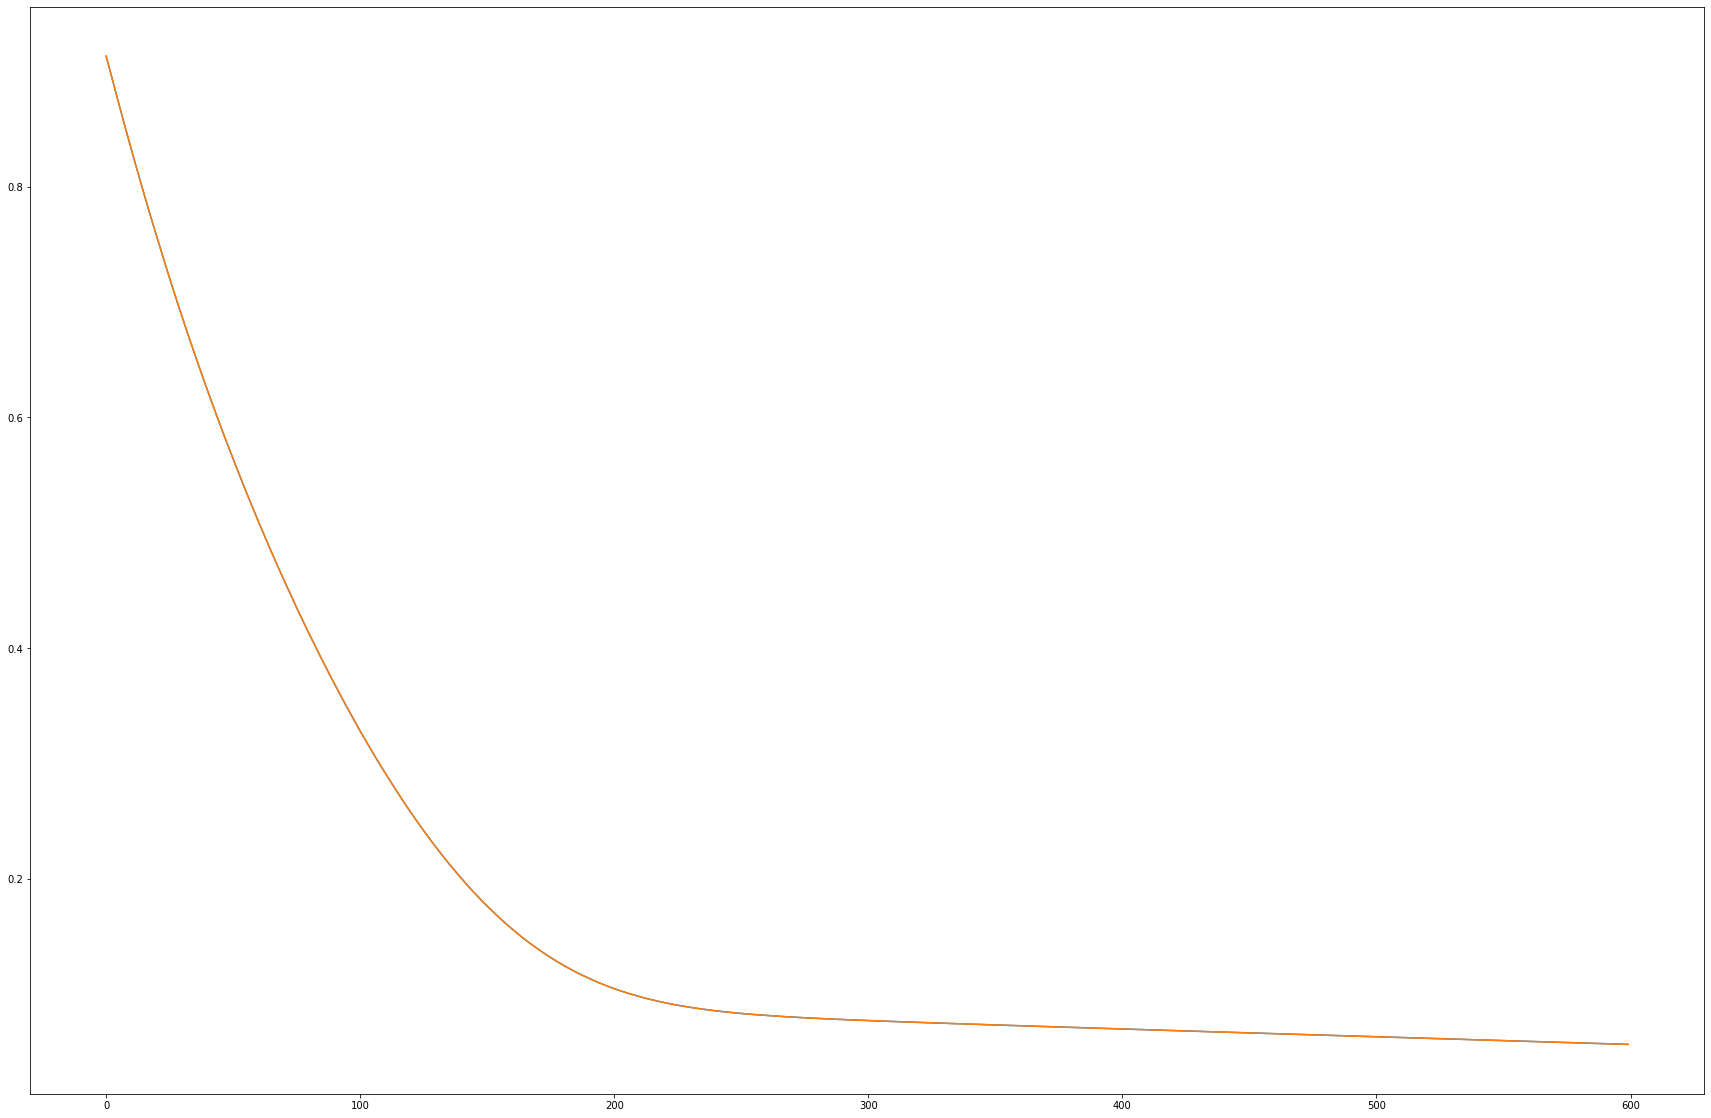

In [9]:
plt.figure(figsize=(30, 20))
plt.plot(w_loss)
plt.plot(r_loss)
plt.show()